<a href="https://colab.research.google.com/github/gregorywmorris/guided_projects/blob/main/time_series/Greg_Hogg/Microsoft_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [2]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-08-22,0.104167,0.105035,0.100694,0.102431,0.063632,5760000
1,1986-08-25,0.102431,0.102431,0.100694,0.102431,0.063632,2419200
2,1986-08-26,0.102431,0.102431,0.101563,0.101563,0.063093,10857600
3,1986-08-27,0.101563,0.102431,0.100694,0.101563,0.063093,9532800
4,1986-08-28,0.101563,0.102431,0.101563,0.101563,0.063093,3427200
...,...,...,...,...,...,...,...
9318,2023-08-15,323.000000,325.089996,320.899994,321.859985,321.179962,16966300
9319,2023-08-16,320.799988,324.420013,319.799988,320.399994,320.399994,20698900
9320,2023-08-17,320.540009,321.869995,316.209991,316.880005,316.880005,21257200
9321,2023-08-18,314.489990,318.380005,311.549988,316.480011,316.480011,24744800


In [3]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-08-22,0.102431
1,1986-08-25,0.102431
2,1986-08-26,0.101563
3,1986-08-27,0.101563
4,1986-08-28,0.101563
...,...,...
9318,2023-08-15,321.859985
9319,2023-08-16,320.399994
9320,2023-08-17,316.880005
9321,2023-08-18,316.480011


In [4]:
df['Date']
# notice date is object, not datetime

0       1986-08-22
1       1986-08-25
2       1986-08-26
3       1986-08-27
4       1986-08-28
           ...    
9318    2023-08-15
9319    2023-08-16
9320    2023-08-17
9321    2023-08-18
9322    2023-08-21
Name: Date, Length: 9323, dtype: object

In [7]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# test
datetime_object = str_to_datetime('1986-08-22')
datetime_object

datetime.datetime(1986, 8, 22, 0, 0)

In [8]:
df

,Date,Close
0,1986-08-22,0.102431
1,1986-08-25,0.102431
2,1986-08-26,0.101563
3,1986-08-27,0.101563
4,1986-08-28,0.101563
...,...,...
9318,2023-08-15,321.859985
9319,2023-08-16,320.399994
9320,2023-08-17,316.880005
9321,2023-08-18,316.480011


In [9]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-9-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-08-22
1      1986-08-25
2      1986-08-26
3      1986-08-27
4      1986-08-28
          ...    
9318   2023-08-15
9319   2023-08-16
9320   2023-08-17
9321   2023-08-18
9322   2023-08-21
Name: Date, Length: 9323, dtype: datetime64[ns]

In [10]:
# convert date to index and remove feature
df.index = df.pop('Date')
df

,Close
Date,
1986-08-22,0.102431
1986-08-25,0.102431
1986-08-26,0.101563
1986-08-27,0.101563
1986-08-28,0.101563
...,...
2023-08-15,321.859985
2023-08-16,320.399994
2023-08-17,316.880005


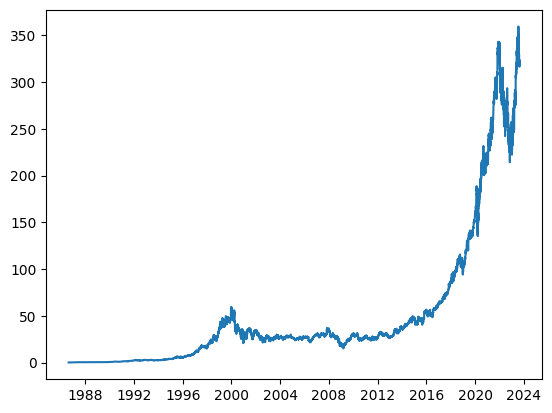

In [11]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [64]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start 1st '1986-09-21'
# Start 2nd '2022-08-21'
# start 3rd '2023-01-01'
# stat 4th '2023-05-21'
# start 5th '2023-08-21' but 200 epochs
windowed_df = df_to_windowed_df(df,
                                '2022-08-21',
                                '2023-08-21',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-08-21,292.709991,291.320007,290.170013,286.149994
1,2022-08-23,290.170013,286.149994,277.750000,276.440002
2,2022-08-24,286.149994,277.750000,276.440002,275.790009
3,2022-08-25,277.750000,276.440002,275.790009,278.850006
4,2022-08-26,276.440002,275.790009,278.850006,268.089996
...,...,...,...,...,...
246,2023-08-15,322.929993,321.010010,324.040009,321.859985
247,2023-08-16,321.010010,324.040009,321.859985,320.399994
248,2023-08-17,324.040009,321.859985,320.399994,316.880005
249,2023-08-18,321.859985,320.399994,316.880005,316.480011


In [65]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # number of obs, window, variable

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32) # float t o fix an errror further in the notebook

dates, X, y = windowed_df_to_date_X_y(windowed_df)

# date, row-window-feature, predictions
dates.shape, X.shape, y.shape

((251,), (251, 3, 1), (251,))

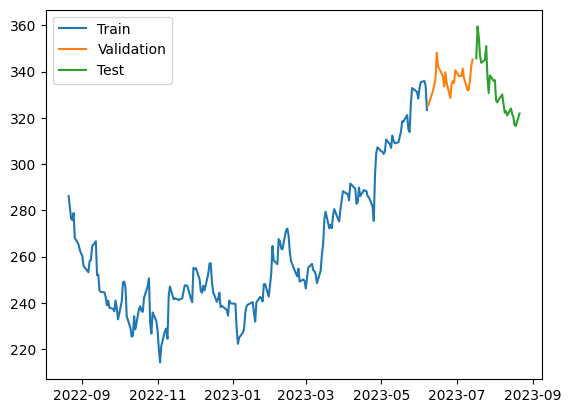

In [66]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # window, feature
                    layers.LSTM(64), # arbitrary choice, bigger more complex danger fo over fitting
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)
# First run 87 epochs determined after a run of 100
# second run 87 & 100 epochs
# 3rd run 100 epochs
# 4th run 100 & 200 epochs
# 5th run 200 epochs

Epoch 1/200
7/7 [==============================] - 3s 136ms/step - loss: 69574.3281 - mean_absolute_error: 262.2113 - val_loss: 113333.6484 - val_mean_absolute_error: 336.6087
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 69443.4062 - mean_absolute_error: 261.9610 - val_loss: 113175.1094 - val_mean_absolute_error: 336.3731
Epoch 3/200
7/7 [==============================] - 0s 20ms/step - loss: 69313.4688 - mean_absolute_error: 261.7119 - val_loss: 112971.9766 - val_mean_absolute_error: 336.0710
Epoch 4/200
7/7 [==============================] - 0s 18ms/step - loss: 69142.7500 - mean_absolute_error: 261.3853 - val_loss: 112736.8203 - val_mean_absolute_error: 335.7210
Epoch 5/200
7/7 [==============================] - 0s 16ms/step - loss: 68947.4844 - mean_absolute_error: 261.0135 - val_loss: 112458.5391 - val_mean_absolute_error: 335.3063
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 68708.6562 - mean_absolute_error: 260.5536 - val_los

7/7 [==============================] - 1s 4ms/step


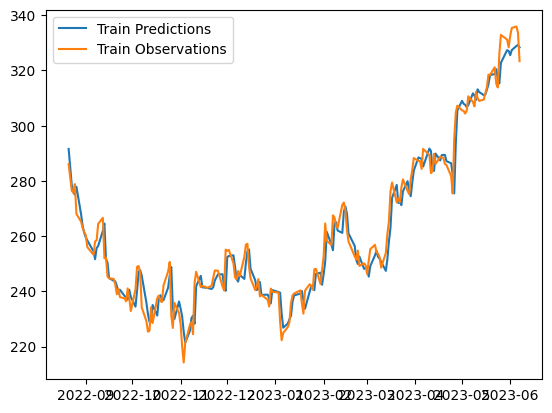

In [68]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Train Predictions', 'Train Observations'])

1/1 [==============================] - 0s 33ms/step


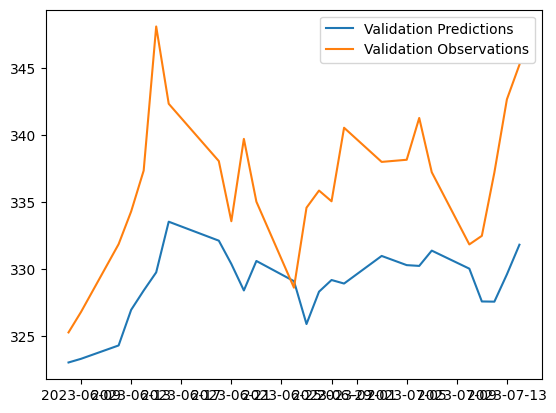

In [69]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 49ms/step


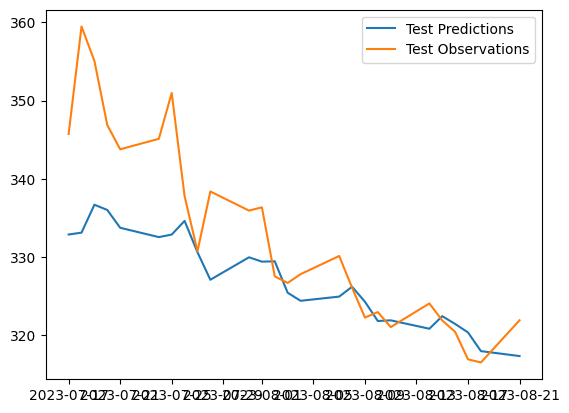

In [70]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

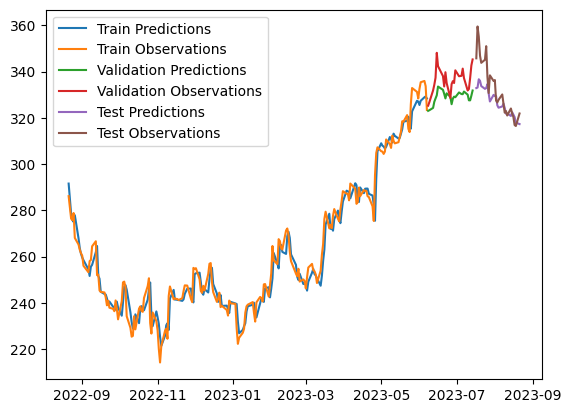

In [72]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Train Predictions',
            'Train Observations',
            'Validation Predictions',
            'Validation Observations',
            'Test Predictions',
            'Test Observations'])
# An intial run showed that the model was unable to make predictions after the rise in 2017
# suggests that historical data may be detrimental and a nearer range would be optimal
# a second run of 1 year is then used

In [73]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test]) # attepmt to make recursive predictions both val and test

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 22ms/step


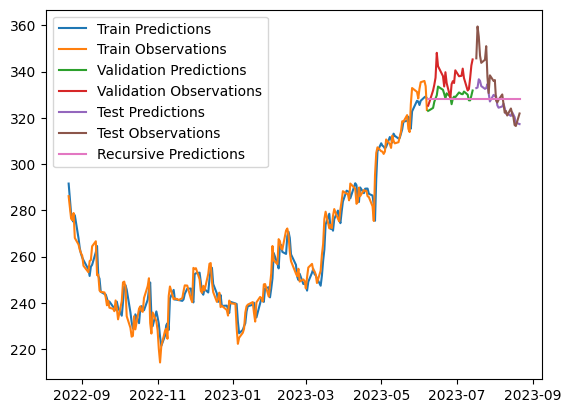

In [74]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Train Predictions',
            'Train Observations',
            'Validation Predictions',
            'Validation Observations',
            'Test Predictions',
            'Test Observations',
            'Recursive Predictions'])

# the models has failed to make recursive prediction